In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Importing all the libraries

In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.constraints import MaxNorm

Importing the dataset

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Threre are 50000 training images of size 32*32, each image has a single label from 0-9,

There are 10000 testing images of size 32*32, each image has a single label from 0-9

Below is a visualization of the images from the dataset:

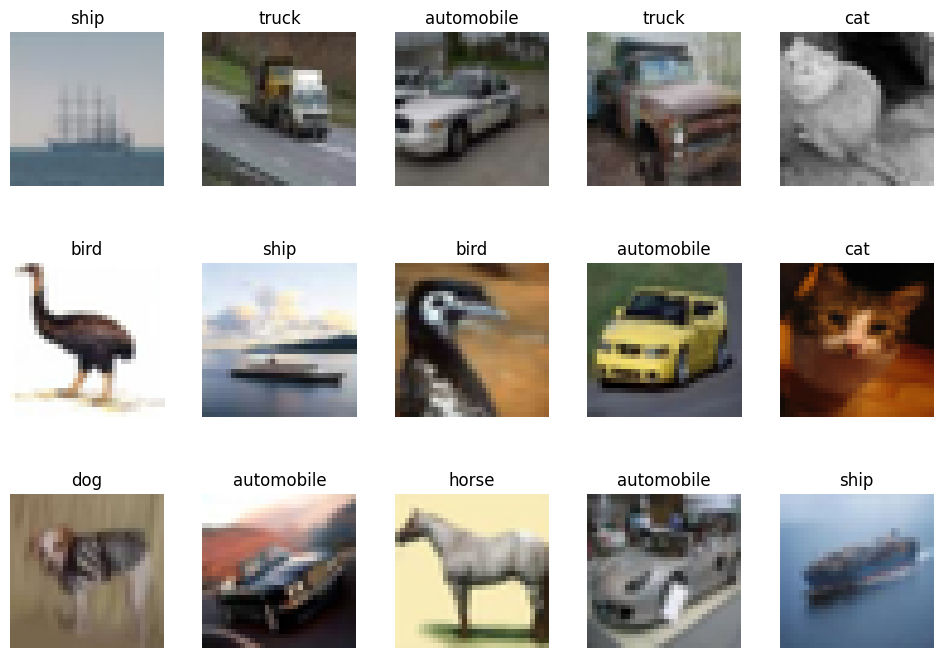

In [ ]:
# Assuming x_train, y_train are loaded and contain CIFAR-10 data
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(3, 5, figsize=(12, 8))
axes = axes.ravel()

for i in range(15):
    index = np.random.randint(0, len(X_train))
    axes[i].imshow(X_train[index])
    axes[i].set_title(class_names[y_train[index][0]])
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.5)

Analyse the dataset distribution (how many class-wise samples are there for training and testing)

C:\Users\NMB\AppData\Local\Temp\ipykernel_22908\4180544181.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(class_names, rotation = 90)


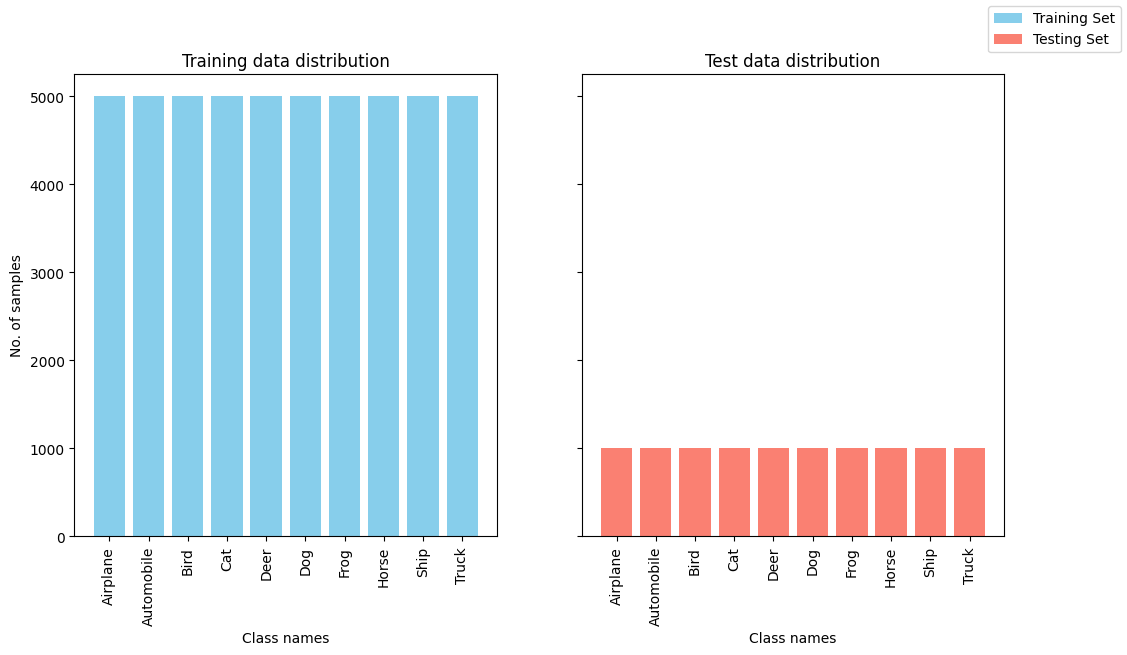

In [ ]:
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
                'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
train_classes, train_counts = np.unique(y_train, return_counts=True)
test_classes, test_counts = np.unique(y_test, return_counts=True)
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot training set distribution
axs[0].bar(class_names, train_counts, color='skyblue')
axs[0].set_title('Training data distribution')
axs[0].set_xlabel('Class names')
axs[0].set_ylabel('No. of samples')
axs[0].set_xticklabels(class_names, rotation = 90)
# Plot testing set distribution
axs[1].bar(class_names, test_counts, color='salmon')
axs[1].set_title('Test data distribution')
axs[1].set_xlabel('Class names')

# Add a legend to clarify the colors represent training and testing sets
fig.legend(['Training Set', 'Testing Set'])

# plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

Data preparation: Divide the training sames into two parts: Trainining and Validation

In [ ]:
from sklearn.model_selection import train_test_split

y_cat_train = to_categorical(y_train, 10)    # Convert the labels from 0-9 to one hot encoded 10-dimensional vectors
y_cat_test = to_categorical(y_test, 10)      # Convert the labels from 0-9 to one hot encoded 10-dimensional vectors

x_train1, x_valid, y_train1, y_valid= train_test_split(X_train, y_cat_train, test_size=0.2, random_state=22)


# Data augementation: Create a data augmentation function for the training and validation sets. During each iteration of training,
# the function will be applied randomly to batch of images to create diverse scenarios throughout the training

train_datagen = ImageDataGenerator(    #standard augmentation
                    rotation_range=10,
                    rescale=1./255,
                    zoom_range=0.1,
                    fill_mode='nearest',
                    horizontal_flip=True,
                    width_shift_range=0.1,
                    height_shift_range=0.1
                    )
valid_datagen = ImageDataGenerator(    #standard augmentation
                    rotation_range=10,
                    rescale=1./255,
                    zoom_range=0.1,
                    fill_mode='nearest',
                    horizontal_flip=True,
                    width_shift_range=0.1,
                    height_shift_range=0.21
                    )

#Data augmentation is not required, only normalization of the pixel values are required during the testing phase

test_datagen = ImageDataGenerator(rescale=1./255)


# # One-Hot Encoding
# y_cat_train = to_categorical(y_train1, 10)
# y_cat_valid = to_categorical(y_valid, 10)
# y_cat_test = to_categorical(y_test, 10)

How to load the data from a directory in the local storage (three folders: train, valid, and test, with each having images)

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Set common parameters
# img_height = 224
# img_width = 224
# batch_size = 32

# # Generate training data
# train_generator = train_datagen.flow_from_directory(
#     'data/train',
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='training',
#     shuffle=True
# )

# # Generate validation data
# valid_generator = train_datagen.flow_from_directory(
#     'data/train',
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='validation',
#     shuffle=True
# )

# # Generate test data
# test_generator = test_datagen.flow_from_directory(
#     'data/test',
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     class_mode='categorical',
#     shuffle=False
# )

In [ ]:
from keras import backend as K
K.clear_session()

Model development

In [ ]:
#This part is to describe the parametes, you can check below for a more compact model version

num_classes=10

# Create the model
model = Sequential()                  # A keras sequential object allows adding layers on top of one another

model.add(
    Conv2D(
        filters=32,                    # Number of output filters/channels
        kernel_size=(3, 3),            # Size of the convolution window
        strides=1,                     # Step size of the convolution
        padding='same',                # Padding strategy (same means output size will be made same as input size)
        input_shape=(32, 32, 3),       # Input dimensions (height, width, channels)
        kernel_initializer='he_normal',# Weight initialization method (other options: https://keras.io/api/layers/initializers/)
        activation='relu'              # Activation function (other options: https://keras.io/api/layers/activations/)
    )
)


model.add(BatchNormalization())      # Normalize activations for faster training
model.add(Dropout(0.2))              # Randomly drop 20% neurons to prevent overfitting

# Second Convolutional Layer in First Block
model.add(
    Conv2D(
        filters=32,                    # Number of output filters/channels
        kernel_size=(3, 3),            # Size of the convolution window
        strides=1,                     # Step size of the convolution
        padding='same',                # Padding strategy
        kernel_initializer='he_normal', # Weight initialization method
        activation='relu'              # Activation function
    )
)
model.add(BatchNormalization())
model.add(MaxPooling2D())              # Reduce spatial dimensions by half (16x16)

# Second Convolutional Block - Doubled filters (64)
model.add(Conv2D(64,
                 (3, 3),
                 strides=1,
                 padding='same',
                 kernel_initializer='he_normal',
                 activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Second Convolutional Layer in Second Block
model.add(Conv2D(64,
                 (3, 3),
                 strides=1,
                 padding='same',
                 kernel_initializer='he_normal',
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())  # Further reduce spatial dimensions (8x8)


# Third Convolutional Block - Doubled filters (128)
model.add(Conv2D(128,
                 (3, 3),
                 strides=1,
                 padding='same',
                 kernel_initializer='he_normal',
                 activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Second Convolutional Layer in Third Block
model.add(Conv2D(128,
                 (3, 3),
                 strides=1,
                 padding='same',
                 activation='relu'))
model.add(MaxPooling2D())                   # Final spatial dimension reduction (4x4)

# Global Average Pooling to replace Flatten
# Reduces parameters and maintains spatial information
model.add(GlobalAveragePooling2D())

# Final Dropout before classification
model.add(Dropout(0.2))

# Output layer with softmax activation for 10-class classification
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
num_classes=10

#Compact model version
# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), strides=1, padding='same', input_shape=(32, 32, 3), kernel_initializer='he_normal', activation='relu' ))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), strides=1, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), strides=1, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), strides=1, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3), strides=1, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

#Compile the model
#Only after compilation, the weights are initialized and other hyper-parameters are considered for training to start

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

#filepath to save the best model
filepath="/content/drive/MyDrive/Colab Notebooks/TimesPro/checkpoint.model_GAP.{epoch:02d}.weights.h5"         # when save_weights_only=True

modelcheckpoint= ModelCheckpoint(filepath=filepath, save_weights_only=True,
                                 monitor='val_accuracy', mode='max', save_best_only=True)
#Define callback
callbacks=[modelcheckpoint]


#Training the model
# 320000 training samples, batch size =32 , 320000/32=1000
history = model.fit(
    train_datagen.flow(x_train1, y_train1, batch_size=32),
    validation_data=valid_datagen.flow(x_valid, y_valid, batch_size=32),
    epochs=100,                        # Set a high number of epochs
    callbacks=callbacks                # Include the early stopping callback
)

#------------------------------------------------------------------------------------------------------------------------------------


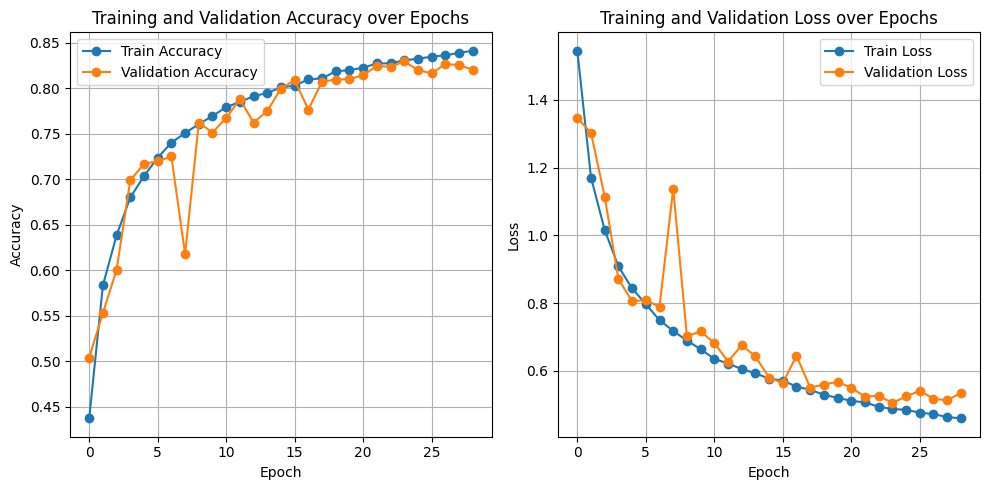

Accuracy: 82.99%


In [ ]:
def plot_convergence():

  plt.figure(figsize=(10, 5))
  # Accuracy plot
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.grid(True)
  plt.legend()

  # Loss plot
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], marker='o', label='Train Loss')
  plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
  plt.title('Training and Validation Loss over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid(True)
  plt.legend()

  plt.tight_layout()
  plt.show()


plot_convergence()


scores = model.evaluate(test_datagen.flow(X_test, y_cat_test,batch_size=32), verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
#Advanced implementations

#Supponse, you model is developed
# till model.add(Dense, activation='Softmax) from the above example
# Another way of compiling and training with more control

sgd = SGD(learning_rate=0.01, momentum=0.9, weight_decay=1e-5, nesterov=False) #Description is given below in detail

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])  #Use the optimizer that is defined: optimizer=sgd

model.summary()

#Check below to know about early stopping
earlystopper = EarlyStopping(
    monitor='val_accuracy',   # Metric to monitor - tracks validation accuracy
    patience=5,               # Number of epochs to wait for improvement
                              # Higher patience allows more exploration
                              # Lower patience stops training earlier
    mode='max',               # 'max' because we want accuracy to increase
                              # Use 'min' for loss monitoring
    verbose=1                 # Print messages when stopping
)

#Check slides and below to know about learning rate reduction
# Learning Rate Reduction Configuration
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',    # Metric to monitor for LR adjustments
    factor=0.5,               # Multiply LR by this factor when plateauing
                             # 0.5 means LR is halved
                             # Smaller factor = more gradual reduction
    patience=5,               # Epochs to wait before reducing LR
                             # Should be similar to early stopping patience
                             # Allows time for current LR to show effect
    verbose=1,                # Print message when LR changes
    mode='max',              # 'max' for accuracy monitoring
                            # Determines direction of improvement
    min_lr=0.00001           # Minimum learning rate allowed
                            # Prevents LR from becoming too small
)

#Model checkpoint saving

filepath="/content/drive/MyDrive/Colab Notebooks/TimesPro/checkpoint.model_GAP.{epoch:02d}.weights.h5"
modelcheckpoint = ModelCheckpoint(
    filepath=filepath,         # Path where model weights will be saved
                              # Example: 'models/best_model_{epoch:02d}.h5'
                              # Can include epoch number and metrics in filename

    save_weights_only=True,    # Only save model weights, not entire architecture
                              # True: Saves only weights (smaller file size)
                              # False: Saves entire model (architecture + weights)

    monitor='val_accuracy',    # Metric to monitor for saving decisions
                              # Tracks validation accuracy improvements
                              # Could also use 'val_loss' for loss monitoring

    mode='max',               # 'max' because we want highest accuracy
                             # Use 'min' for loss monitoring
                             # Determines what counts as improvement

    save_best_only=True       # Only save when model improves
                             # Prevents saving unnecessary checkpoints
                             # Saves storage space
)

callbacks=[earlystopper, reduce_lr, modelcheckpoint]


In [ ]:
#Another Version of model devlopment using the above conecpts

num_classes=10

#Compact model version
# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), strides=1, padding='same', input_shape=(32, 32, 3), kernel_initializer='he_normal', activation='relu' ))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), strides=1, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), strides=1, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), strides=1, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3), strides=1, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

#Compile the model
sgd = SGD(learning_rate=0.01, momentum=0.9, weight_decay=1e-5, nesterov=False)       #Description is given below in detail

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])  #Use the optimizer that is defined: optimizer=sgd

model.summary()

earlystopper = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)  #Descriptions are given below

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5,            #Descriptions are given below
                                   verbose=1, mode='max', min_lr=0.00001)

filepath="/content/drive/MyDrive/Colab Notebooks/TimesPro/checkpoint.model_GAP.{epoch:02d}.keras"              #  checkpoint saving the whole model (default)
filepath="/content/drive/MyDrive/Colab Notebooks/TimesPro/checkpoint.model_GAP.{epoch:02d}.weights.h5"         # when save_weights_only=True

modelcheckpoint= ModelCheckpoint(filepath=filepath, save_weights_only=True,
                                 monitor='val_accuracy', mode='max', save_best_only=True)

callbacks=[earlystopper, reduce_lr, modelcheckpoint]


history = model.fit(
    train_datagen.flow(x_train1, y_train1, batch_size=32),
    validation_data=valid_datagen.flow(x_valid, y_valid, batch_size=32),
    epochs=100,                                       # Set a high number of epochs
    callbacks=callbacks                               # Include the early stopping callback


#Train the model and evaluate

In [ ]:

earlystopper = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)
# ## Parameter Configuration

# monitor='val_accuracy': The callback tracks the model's accuracy on the validation dataset.

# patience=5: Training will continue for 5 epochs after the validation accuracy stops improving. If no improvement occurs during these 5 epochs, the training process will terminate.

# mode='max': Indicates that improvements are recognized when the monitored metric (validation accuracy) increases. This makes sense for accuracy monitoring, as higher accuracy values are better.

# verbose=1: Enables progress messages that inform when training stops due to early stopping.

# ## Benefits

# Early stopping provides several key advantages:

# - Prevents overfitting by halting training when the model stops improving on validation data.
# - Conserves computational resources by avoiding unnecessary training epochs.
# - Enhances the model's ability to generalize to unseen data.
# - Automatically saves the best model weights during training when used with appropriate configuration.

# ## Example Usage

# ```python
# model.fit(x_train, y_train,
#           epochs=100,
#           validation_data=(x_val, y_val),
#           callbacks=[earlystopper])
# ```

# This setup will automatically stop training when the validation accuracy plateaus, helping to find the optimal point between underfitting and overfitting.


In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5,
                                    verbose=1, mode='max', min_lr=0.00001)

# ## Parameter Configuration

# monitor='val_accuracy': Tracks the validation accuracy to determine when to adjust the learning rate.

# factor=0.5: When triggered, the learning rate is reduced by half (multiplied by 0.5).

# patience=5: Waits for 5 epochs without improvement before reducing the learning rate.

# verbose=1: Prints messages when the learning rate changes.

# mode='max': Specifies that improvement means higher values of the monitored metric.

# min_lr=0.00001: Sets the lower bound for the learning rate to prevent it from becoming too small.

# ## How It Works

# ```python
# # Example usage with model training
# model.fit(x_train, y_train,
#           epochs=100,
#           validation_data=(x_val, y_val),
#           callbacks=[reduce_lr])
# ```

# ## Advantages

# - Adaptive Learning: Automatically adjusts the learning rate when training plateaus, helping overcome local minima.
# - Training Stability: Smaller learning rates help fine-tune the model in later stages of training.
# - Better Convergence: Reduces oscillations around the optimal point by decreasing step sizes.
# - Automation: Eliminates the need for manual learning rate scheduling.

# ## Practical Impact

# When the model's performance plateaus, reducing the learning rate allows for:
# - More precise weight updates
# - Exploration of finer features in the data
# - Better final model accuracy
# - Smoother convergence to the optimal solution

# This callback is particularly useful in deep learning models where finding the right learning rate schedule can be challenging.

In [ ]:

sgd = SGD(learning_rate=0.01, momentum=0.9, weight_decay=1e-5, nesterov=False)

#momentum=0.9

#     Extensively tested in research literature
#     Provides optimal balance between:
#         Speed of convergence
#         Training stability
#         Escape from local minima
#     Works well across different architectures and datasets
#     Changing it often degrades performance

# weight_decay=1e-5

#     Proven effective for most CNN architectures
#     Provides sufficient regularization without being too aggressive
#     Scale-appropriate for modern neural networks
#     Higher values often lead to underfitting
#     Lower values may not provide enough regularization

# nesterov=False

#     Classical momentum is more stable and reliable
#     Nesterov momentum is more sensitive to hyperparameters
#     Additional complexity of Nesterov rarely provides significant benefits
#     Classical momentum has better empirical results across various tasks

# These parameters have been extensively studied and optimized through years of deep learning research, making them reliable defaults for most applications.

In [ ]:

# ## Code Components

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    0.01,           #initial_learning_rate
    20,             #decay_steps,
    alpha=0.0,
    name=None,
    warmup_target=None,
    warmup_steps=0
)
sgd = SGD(learning_rate=lr_schedule, momentum=0.9, weight_decay=1e-5, nesterov=False)


# ## Learning Rate Schedule Parameters

# Initial Configuration:
# - Starting learning rate is set to 0.01, which defines the maximum learning rate at the beginning
# - The learning rate will decay over 20 steps, controlling the speed of decay
# - Alpha is set to 0.0, meaning the learning rate will decay completely to zero

# Decay Pattern:
# The learning rate follows a cosine curve that gradually decreases from the initial value (0.01) to alpha*initial_value (0 in this case). The decay is calculated as:

# lr = 0.01 * (0.5 * (1 + cos(pi * step / 20)))

# ## SGD Optimizer Settings

# Configuration Details:
# - Momentum of 0.9 helps accelerate gradient descent
# - Weight decay of 1e-5 provides regularization
# - Nesterov momentum is disabled

# ## Use Cases

# This configuration is particularly effective for:

# - Training deep neural networks where you want to start with larger learning steps and gradually refine the learning
# - Scenarios requiring careful convergence near the end of training
# - Models that benefit from a smooth learning rate transition rather than step-wise decay

# ## Advantages

# - The cosine decay provides smoother transitions compared to step decay
# - The schedule automatically handles learning rate reduction without manual intervention
# - The combination with SGD optimizer makes it suitable for various deep learning tasks


- https://keras.io/2.15/api/
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
- https://www.tensorflow.org/api_docs/python/tf/keras/layers
- https://keras.io/2.15/api/callbacks/
- https://keras.io/api/layers/initializers/
- https://keras.io/api/callbacks/early_stopping/
- https://keras.io/api/callbacks/reduce_lr_on_plateau/
- https://keras.io/api/callbacks/csv_logger/


